<a href="https://colab.research.google.com/github/kaushikkumarkr/Sales-Forecasting-and-Visualization/blob/main/Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Data

As we are using Google Colab, we will connect to Google Drive to access our dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [ ]:
path='/content/drive/My Drive/Colab Notebooks/Dataset/sales_data.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np



In [ ]:
# Load the Sales dataset
sales_data = pd.read_csv(path)

In [ ]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Region          100000 non-null  object 
 1   Country         100000 non-null  object 
 2   Item Type       100000 non-null  object 
 3   Sales Channel   100000 non-null  object 
 4   Order Priority  100000 non-null  object 
 5   Order Date      100000 non-null  object 
 6   Order ID        100000 non-null  int64  
 7   Ship Date       100000 non-null  object 
 8   Units Sold      100000 non-null  int64  
 9   Unit Price      100000 non-null  float64
 10  Unit Cost       100000 non-null  float64
 11  Total Revenue   100000 non-null  float64
 12  Total Cost      100000 non-null  float64
 13  Total Profit    100000 non-null  float64
dtypes: float64(5), int64(2), object(7)
memory usage: 10.7+ MB


In [ ]:
sales_data.describe()

,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
count,1.000000e+05,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05
mean,5.503956e+08,5001.446170,266.703989,188.019711,1.336067e+06,9.419755e+05,3.940912e+05
std,2.593219e+08,2884.575424,216.940081,175.706023,1.471768e+06,1.151828e+06,3.795986e+05
min,1.000089e+08,1.000000,9.330000,6.920000,1.866000e+01,1.384000e+01,4.820000e+00
25%,3.260464e+08,2505.000000,109.280000,56.670000,2.797533e+05,1.629283e+05,9.590000e+04
50%,5.477185e+08,5007.000000,205.700000,117.110000,7.898916e+05,4.679374e+05,2.836575e+05
75%,7.750785e+08,7495.250000,437.200000,364.690000,1.836490e+06,1.209475e+06,5.683841e+05
max,9.999965e+08,10000.000000,668.270000,524.960000,6.682700e+06,5.249075e+06,1.738700e+06


In [ ]:
sales_data.corr()

<ipython-input-8-4f52a22a580c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sales_data.corr()


,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
Order ID,1.000000,0.000583,-0.000751,0.000005,0.001699,0.002334,-0.000497
Units Sold,0.000583,1.000000,0.003453,0.003167,0.525322,0.472966,0.601624
Unit Price,-0.000751,0.003453,1.000000,0.986030,0.739258,0.754412,0.577093
Unit Cost,0.000005,0.003167,0.986030,1.000000,0.729055,0.765211,0.504763
Total Revenue,0.001699,0.525322,0.739258,0.729055,1.000000,0.987691,0.880186
Total Cost,0.002334,0.472966,0.754412,0.765211,0.987691,1.000000,0.795110
Total Profit,-0.000497,0.601624,0.577093,0.504763,0.880186,0.795110,1.000000


##Preprocessing

In [ ]:

from sklearn.impute import SimpleImputer

# Create an instance of SimpleImputer with mean strategy
imputer = SimpleImputer(strategy='mean')

# Fit the imputer to the data
imputer.fit(df)

# Transform the data by imputing missing values
df = imputer.transform(X)


In [ ]:
# Feature selection using correlation analysis
correlation_matrix = df.corr()
selected_features = correlation_matrix[correlation_matrix['Total Profit'] > 0.5].index.tolist()



In [ ]:
# Data standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Total Profit', 'Total Revenue']])
df[['Total Profit', 'Total Revenue']] = scaled_data



In [ ]:
# One-hot encoding
encoded_data = pd.get_dummies(df['Region'])
df = pd.concat([df, encoded_data], axis=1)
df.drop(['Region'], axis=1, inplace=True)



In [ ]:

# Checking duplicate records
duplicates = df.duplicated()
duplicate_count = duplicates.sum()
if duplicate_count > 0:
    print(f"Found {duplicate_count} duplicate records.")



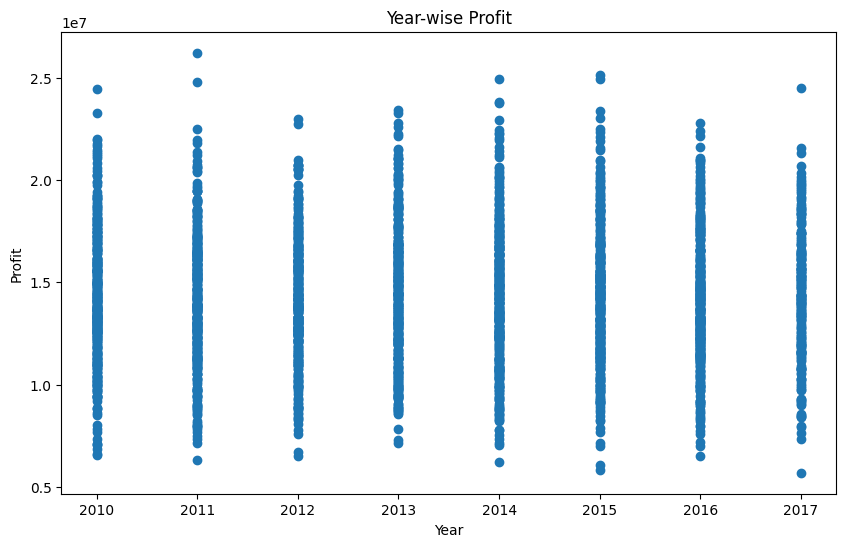

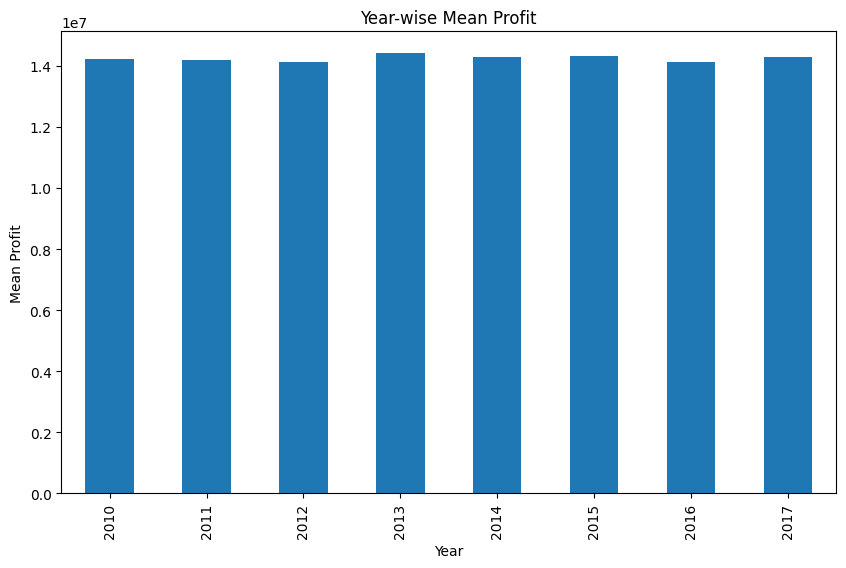

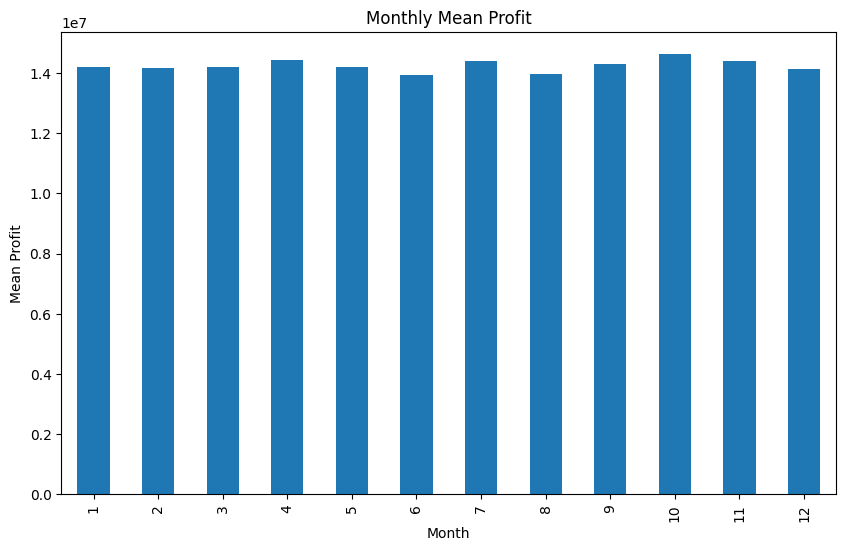

In [ ]:



# Data Preprocessing
preprocessed_data = sales_data.groupby('Order Date').agg({'Total Profit': 'sum'}).reset_index()

# Extract year and month from the Order Date
preprocessed_data['Order Date'] = pd.to_datetime(preprocessed_data['Order Date'])
preprocessed_data['Year'] = preprocessed_data['Order Date'].dt.year
preprocessed_data['Month'] = preprocessed_data['Order Date'].dt.month

# Exploratory Data Analysis
yearly_profit_mean = preprocessed_data.groupby('Year')['Total Profit'].mean()
monthly_profit_mean = preprocessed_data.groupby('Month')['Total Profit'].mean()

# Scatter plot of Year vs. Profit
plt.figure(figsize=(10, 6))
plt.scatter(preprocessed_data['Year'], preprocessed_data['Total Profit'])
plt.xlabel('Year')
plt.ylabel('Profit')
plt.title('Year-wise Profit')
plt.show()

# Bar graph of Year vs. Mean Profit
plt.figure(figsize=(10, 6))
yearly_profit_mean.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Mean Profit')
plt.title('Year-wise Mean Profit')
plt.show()

# Bar graph of Month vs. Mean Profit
plt.figure(figsize=(10, 6))
monthly_profit_mean.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Mean Profit')
plt.title('Monthly Mean Profit')
plt.show()



In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the sales dataset
sales_data = pd.read_csv(path)

# Data Preprocessing
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])
sales_data['Year'] = sales_data['Order Date'].dt.year
preprocessed_data = sales_data.groupby('Year')['Total Profit'].sum().reset_index()

# Split the data into training and testing sets
train_data = preprocessed_data[:-1]
test_data = preprocessed_data[-1:]

# SARIMA Model
sarima_model = SARIMAX(train_data['Total Profit'], order=(1,1,1), seasonal_order=(0, 1, 1, 12))
sarima_model_fit = sarima_model.fit(disp=False)
sarima_predictions = sarima_model_fit.forecast(steps=1)

# LSTM Model
train_X = np.array(train_data['Total Profit']).reshape(-1, 1)
train_y = np.array(train_data['Total Profit']).reshape(-1, 1)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(train_X, train_y, epochs=20, batch_size=64, verbose=0)

lstm_predictions = model.predict(np.array(test_data['Total Profit']).reshape(-1, 1))

# Calculate metrics
sarima_mse = mean_squared_error(test_data['Total Profit'], sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)

lstm_mse = mean_squared_error(test_data['Total Profit'], lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)

# Print the predictions and metrics
print("SARIMA Predictions:")
print(sarima_predictions)
print("SARIMA MSE:", sarima_mse)
print("SARIMA RMSE:", sarima_rmse)
print()

print("LSTM Predictions:")
print(lstm_predictions)
print("LSTM MSE:", lstm_mse)
print("LSTM RMSE:", lstm_rmse)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


1/1 [==============================] - 0s 204ms/step
SARIMA Predictions:
7    5.166950e+09
dtype: float64
SARIMA MSE: 4.765410989548118e+18
SARIMA RMSE: 2182982132.21

LSTM Predictions:
[[3.19304e+08]]
LSTM MSE: 7.100435330737611e+18
LSTM RMSE: 2664664206.0


In [ ]:
import pandas as pd
import pmdarima as pm

# Load your dataset into a DataFrame (assuming it's already preprocessed)
df = pd.read_csv(path)

# Extract the target variable (Total Profit) from the DataFrame
y = df['Total Profit']

# Use auto_arima to find the best seasonal and non-seasonal orders
model = pm.auto_arima(y, seasonal=True, m=12, suppress_warnings=True)

# Get the best orders from the fitted model
order = model.order
seasonal_order = model.seasonal_order

# Print the best orders
print("Best Model - Parameters: ", order, seasonal_order)


##Preprocessing and Predicting -> LSTM (Month) - Total Profit

In [ ]:
# Data preprocessing for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(preprocessed_data[['Total Profit']].values)

# Split the data into training and testing sets
train_data = data_scaled[:-12]  # Use all data except the last 12 months for training
test_data = data_scaled[-12:]  # Use the last 12 months for testing

# Define the parameters for LSTM
length = 12  # Length of input sequences

# Prepare the training data for LSTM
train_X = []
train_y = []
for i in range(length, len(train_data)):
    train_X.append(train_data[i-length:i])
    train_y.append(train_data[i])

train_X = np.array(train_X)
train_y = np.array(train_y)

# Reshape the input data for LSTM
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model.fit(train_X, train_y, epochs=20, batch_size=64, verbose=1)

# Generate sequences for the next 12 months
future_data = test_data[-length:]
future_generator = TimeseriesGenerator(future_data, future_data, length=1, batch_size=1)

# Make predictions for the next 12 months
future_predictions_date = model.predict(future_generator)

# Inverse transform the predictions to get the actual profit values
future_predictions_date = scaler.inverse_transform(future_predictions_date)

# Print the predicted profits for the next 12 months
for i in range(len(future_predictions_date)):
    print(f"Month {i+1}: Predicted Profit = {future_predictions_date[i][0]}")

In [ ]:
preprocessed_data

,Order Date,Total Profit,Year,Month
0,2010-01-01,15791379.47,2010,1
1,2011-01-01,19057737.43,2011,1
2,2012-01-01,18554097.90,2012,1
3,2013-01-01,9807679.74,2013,1
4,2014-01-01,12736337.29,2014,1
...,...,...,...,...
2761,2012-09-09,10287148.86,2012,9
2762,2013-09-09,8873616.94,2013,9
2763,2014-09-09,10322679.30,2014,9
2764,2015-09-09,18540821.89,2015,9


In [ ]:
future_predictions_date

array([[7614780.5],
       [7646805. ],
       [7596782. ],
       [7583817. ],
       [7593195.5],
       [7778157.5],
       [7596281.5],
       [7590459.5],
       [7567879.5],
       [7590817.5],
       [7732604. ]], dtype=float32)

#LSTM Region, Country - Total Profit

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Load the Sales dataset
sales_data = pd.read_csv(path)

# Data Preprocessing
preprocessed_data = sales_data.groupby(['Region', 'Country', 'Order Date']).agg({'Total Profit': 'sum'}).reset_index()

# Group by Region and build LSTM models
regions = preprocessed_data['Region'].unique()

# Dictionary to store the predictions
predictions_regioncountry = {}

for region in regions:
    region_data = preprocessed_data[preprocessed_data['Region'] == region]

    # Group by Country within the Region and build LSTM models
    countries = region_data['Country'].unique()

    for country in countries:
        country_data = region_data[region_data['Country'] == country]

        # Data preprocessing
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(country_data[['Total Profit']].values)

        # Split the data into training and testing sets
        train_data = data_scaled[:-12]  # Use all data except the last 12 months for training
        test_data = data_scaled[-12:]  # Use the last 12 months for testing

        # Define the parameters for LSTM
        length = 12  # Length of input sequences

        # Prepare the training data for LSTM
        train_X = []
        train_y = []
        for i in range(length, len(train_data)):
            train_X.append(train_data[i-length:i])
            train_y.append(train_data[i])

        train_X = np.array(train_X)
        train_y = np.array(train_y)

        # Reshape the input data for LSTM
        train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(100, activation='relu', input_shape=(length, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Train the LSTM model
        model.fit(train_X, train_y, epochs=20, batch_size=64, verbose=1)

        # Generate sequences for the next 12 months
        future_data = test_data[-length:]
        future_generator = TimeseriesGenerator(future_data, future_data, length=1, batch_size=1)

        # Make predictions for the next 12 months
        future_predictions = model.predict(future_generator)

        # Inverse transform the predictions to get the actual profit values
        future_predictions = scaler.inverse_transform(future_predictions)

        # Store the predictions in the dictionary
        key = f"Region: {region}, Country: {country}"
        predictions_regioncountry[key] = future_predictions.flatten()

# Print all the predictions
for key, pred in predictions_regioncountry.items():
    print(key)
    for i, val in enumerate(pred):
        print(f"Month {i+1}: {val}")
    print()

#LSTM - Item type and total profit

In [ ]:
#LSTM - Item type and total profit

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Load the Sales dataset
sales_data = pd.read_csv(path)

# Data Preprocessing
preprocessed_data = sales_data.groupby(['Item Type', 'Order Date']).agg({'Total Profit': 'sum'}).reset_index()

# Group by Item Type and build LSTM models
item_types = preprocessed_data['Item Type'].unique()

# Dictionary to store the predictions
predictions_type = {}

for item_type in item_types:
    item_data = preprocessed_data[preprocessed_data['Item Type'] == item_type]

    # Data preprocessing
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(item_data[['Total Profit']].values)

    # Split the data into training and testing sets
    train_data = data_scaled[:-12]  # Use all data except the last 12 months for training
    test_data = data_scaled[-12:]  # Use the last 12 months for testing

    # Define the parameters for LSTM
    length = 12  # Length of input sequences

    # Prepare the training data for LSTM
    train_X = []
    train_y = []
    for i in range(length, len(train_data)):
        train_X.append(train_data[i-length:i])
        train_y.append(train_data[i])

    train_X = np.array(train_X)
    train_y = np.array(train_y)

    # Reshape the input data for LSTM
    train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the LSTM model
    model.fit(train_X, train_y, epochs=20, batch_size=64, verbose=1)

    # Generate sequences for the next 12 months
    future_data = test_data[-length:]
    future_generator = TimeseriesGenerator(future_data, future_data, length=1, batch_size=1)

    # Make predictions for the next 12 months
    future_predictions = model.predict(future_generator)

    # Inverse transform the predictions to get the actual profit values
    future_predictions = scaler.inverse_transform(future_predictions)

    # Store the predictions in the dictionary
    predictions_type[item_type] = future_predictions.flatten()

# Print all the predictions
for item_type, pred in predictions_type.items():
    print(f"Item Type: {item_type}")
    for i, val in enumerate(pred):
        print(f"Month {i+1}: {val}")
    print()


#LSTM - Region, Country ,item type ,order date  - Total profit and total revenue

In [ ]:
#LSTM - Country , region ,item type ,order date  - Total profit and total revenue

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the Sales dataset
sales_data = pd.read_csv(path)

# Data Preprocessing
preprocessed_data = sales_data.groupby(['Country', 'Region', 'Item Type', 'Order Date']).agg({'Total Profit': 'sum', 'Total Revenue': 'sum', 'Total Cost': 'sum'}).reset_index()

# Group by Country, Region, and Item Type and build LSTM models
countries = preprocessed_data['Country'].unique()
regions = preprocessed_data['Region'].unique()
item_types = preprocessed_data['Item Type'].unique()

# Dictionary to store the predictions
predictions_all = {}

for country in countries:
    for region in regions:
        for item_type in item_types:
            data = preprocessed_data[(preprocessed_data['Country'] == country) & (preprocessed_data['Region'] == region) & (preprocessed_data['Item Type'] == item_type)]

            # Check if data is not empty
            if not data.empty:

                # Data preprocessing
                scaler = MinMaxScaler(feature_range=(0, 1))
                data_scaled = scaler.fit_transform(data[['Total Profit', 'Total Revenue']].values)

                # Split the data into training and testing sets
                train_data = data_scaled[:-12]  # Use all data except the last 12 months for training
                test_data = data_scaled[-12:]  # Use the last 12 months for testing

                # Define the parameters for LSTM
                length = 12  # Length of input sequences

                # Prepare the training data for LSTM
                train_X = []
                train_y = []
                for i in range(length, len(train_data)):
                    train_X.append(train_data[i-length:i])
                    train_y.append(train_data[i])

                train_X = np.array(train_X)
                train_y = np.array(train_y)

                # Reshape the input data for LSTM
                train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], train_X.shape[2]))

                # Define the file path to save the model weights
                filepath = f"model_{country}_{region}_{item_type}.h5"

                # Define the ModelCheckpoint callback to save the best model during training
                checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

                # Build the LSTM model
                model = Sequential()
                model.add(LSTM(100, activation='relu', input_shape=(length, 2)))
                model.add(Dense(2))  # Output layer with 2 nodes for profit and revenue
                model.compile(optimizer='adam', loss='mse')

                # Train the LSTM model
                model.fit(train_X, train_y, epochs=10, batch_size=128, verbose=1, callbacks=[checkpoint])

                # Save the trained model
                model.save(filepath)

                # Generate sequences for the next 12 months
                future_data = test_data[-length:]
                future_generator = TimeseriesGenerator(future_data, future_data, length=1, batch_size=1)

                # Make predictions for the next 12 months
                future_predictions = model.predict(future_generator)

                # Inverse transform the predictions to get the actual values
                future_predictions = scaler.inverse_transform(future_predictions)

                # Store the predictions in the dictionary
                key = (country, region, item_type)
                predictions_all[key] = future_predictions.flatten()

# Print all the predictions
for key, pred in predictions_all.items():
    country, region, item_type = key
    print(f"Country: {country} | Region: {region} | Item Type: {item_type}")
    for i, val in enumerate(pred):
        print(f"Month {i+1}: {val}")
    print()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 2s 2s/step - loss: 0.1716
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 0.1637
Epoch 2: loss improved from 0.17156 to 0.16365, saving model to model_Equatorial Guinea_Sub-Saharan Africa_Snacks.h5
1/1 [==============================] - 0s 77ms/step - loss: 0.1637
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.1562
Epoch 3: loss improved from 0.16365 to 0.15620, saving model to model_Equatorial Guinea_Sub-Saharan Africa_Snacks.h5
1/1 [==============================] - 0s 79ms/step - loss: 0.1562
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 0.1488
Epoch 4: loss improved from 0.15620 to 0.14883, saving model to model_Equatorial Guinea_Sub-Saharan Africa_Snacks.h5
1/1 [==============================] - 0s 85ms/step - loss: 0.1488
Epoch 5/10
1/1 [==============================] - ETA: 0s - loss: 0.1414
Epoch 5: loss improved from 0.14883 to 0

IndexError: ignored

# SARIMA Model Country, Region - Total Profit

In [ ]:
# SARIMA Model
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import statsmodels.api as sm

# Load the Sales dataset
sales_data = pd.read_csv(path)

# Data Preprocessing
preprocessed_data = sales_data.groupby(['Country', 'Region', 'Item Type', 'Order Date']).agg({'Total Profit': 'sum', 'Total Revenue': 'sum', 'Total Cost': 'sum'}).reset_index()

# Group by Country, Region, and Item Type and build SARIMA models
countries = preprocessed_data['Country'].unique()
regions = preprocessed_data['Region'].unique()
item_types = preprocessed_data['Item Type'].unique()

# Dictionary to store the predictions
predictions_all = {}

for country in countries:
    for region in regions:
        for item_type in item_types:
            data = preprocessed_data[(preprocessed_data['Country'] == country) & (preprocessed_data['Region'] == region) & (preprocessed_data['Item Type'] == item_type)]

            # Check if data is not empty
            if not data.empty:
                # Prepare the data for SARIMA
                train_data = data[['Order Date', 'Total Profit']]
                train_data['Order Date'] = pd.to_datetime(train_data['Order Date'])
                train_data.set_index('Order Date', inplace=True)

                # Check for stationarity
                is_stationary = sm.tsa.stattools.adfuller(train_data['Total Profit'])[1] > 0.05
                if is_stationary:
                    # Difference the data to make it stationary
                    train_data = train_data.diff().dropna()

                # Define the parameters for SARIMA
                order = (1, 1, 1)  # (p, d, q)
                seasonal_order = (0, 1, 1, 12)  # (P, D, Q, s)

                # Build the SARIMA model
                model = sm.tsa.statespace.SARIMAX(train_data, order=order, seasonal_order=seasonal_order)

                # Train the SARIMA model
                model_fit = model.fit()

                # Generate predictions for the next 12 months
                future_predictions = model_fit.get_forecast(steps=12)
                pred_values = future_predictions.predicted_mean.values

                # Store the predictions in the dictionary
                key = (country, region, item_type)
                predictions_all[key] = pred_values

# Print all the predictions
for key, pred in predictions_all.items():
    country, region, item_type = key
    print(f"Country: {country} | Region: {region} | Item Type: {item_type}")
    for i, val in enumerate(pred):
        print(f"Month {i+1}: {val}")
    print()


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, f

Streaming output truncated to the last 5000 lines.
Month 12: 473799.3034167191

Country: Sudan | Region: Sub-Saharan Africa | Item Type: Clothes
Month 1: 517115.7356361047
Month 2: 685919.4917132542
Month 3: 434739.0975216487
Month 4: 364537.46422232006
Month 5: 239083.35912628687
Month 6: 497640.7574418365
Month 7: 389200.6631367344
Month 8: 545147.0382383184
Month 9: 592445.9014016615
Month 10: 532587.9442363887
Month 11: 586295.7255000531
Month 12: 536547.9605683468

Country: Sudan | Region: Sub-Saharan Africa | Item Type: Cosmetics
Month 1: 1161668.2823489592
Month 2: 923004.697923056
Month 3: 504139.1959746804
Month 4: 1100066.3780974234
Month 5: 587619.07709875
Month 6: 943491.0827974719
Month 7: 795208.3832351292
Month 8: 715513.330806167
Month 9: 1092392.9664851115
Month 10: 788732.872904113
Month 11: 662800.385684746
Month 12: 1291186.0780963604

Country: Sudan | Region: Sub-Saharan Africa | Item Type: Fruits
Month 1: 7268.7155176464685
Month 2: 10273.889827020981
Month 3: 899

### SARIMA Total profit and total revenue - 12 Months

In [ ]:
# SARIMA Total profit and total revenue - 12 Months

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import statsmodels.api as sm

# Load the Sales dataset
sales_data = pd.read_csv(path)

# Data Preprocessing
preprocessed_data = sales_data.groupby(['Country', 'Region', 'Item Type', 'Order Date']).agg({'Total Profit': 'sum', 'Total Revenue': 'sum', 'Total Cost': 'sum'}).reset_index()

# Group by Country, Region, and Item Type and build SARIMA models
countries = preprocessed_data['Country'].unique()
regions = preprocessed_data['Region'].unique()
item_types = preprocessed_data['Item Type'].unique()

# Dictionary to store the predictions
predictions_total = {}

for country in countries:
    for region in regions:
        for item_type in item_types:
            data = preprocessed_data[(preprocessed_data['Country'] == country) & (preprocessed_data['Region'] == region) & (preprocessed_data['Item Type'] == item_type)]

            # Check if data is not empty
            if not data.empty:
                # Prepare the data for SARIMA
                train_data = data[['Order Date', 'Total Profit', 'Total Revenue']]
                train_data['Order Date'] = pd.to_datetime(train_data['Order Date'])
                train_data.set_index('Order Date', inplace=True)

                # Check for stationarity
                is_stationary_profit = sm.tsa.stattools.adfuller(train_data['Total Profit'])[1] > 0.05
                is_stationary_revenue = sm.tsa.stattools.adfuller(train_data['Total Revenue'])[1] > 0.05

                if is_stationary_profit:
                    # Difference the Total Profit data to make it stationary
                    train_data['Total Profit'] = train_data['Total Profit'].diff().dropna()

                if is_stationary_revenue:
                    # Difference the Total Revenue data to make it stationary
                    train_data['Total Revenue'] = train_data['Total Revenue'].diff().dropna()

                # Define the parameters for SARIMA
                order = (1, 1, 1)  # (p, d, q)
                seasonal_order = (0, 1, 1, 12)  # (P, D, Q, s)

                # Build the SARIMA model for Total Profit
                model_profit = sm.tsa.statespace.SARIMAX(train_data['Total Profit'], order=order, seasonal_order=seasonal_order)

                # Train the SARIMA model for Total Profit
                model_fit_profit = model_profit.fit()

                # Build the SARIMA model for Total Revenue
                model_revenue = sm.tsa.statespace.SARIMAX(train_data['Total Revenue'], order=order, seasonal_order=seasonal_order)

                # Train the SARIMA model for Total Revenue
                model_fit_revenue = model_revenue.fit()

                # Generate predictions for the next 12 months for Total Profit
                future_predictions_profit = model_fit_profit.get_forecast(steps=12)
                pred_values_profit = future_predictions_profit.predicted_mean.values

                # Generate predictions for the next 12 months for Total Revenue
                future_predictions_revenue = model_fit_revenue.get_forecast(steps=12)
                pred_values_revenue = future_predictions_revenue.predicted_mean.values

                # Store the predictions in the dictionary
                key = (country, region, item_type)
                predictions_total[key] = {'Total Profit': pred_values_profit, 'Total Revenue': pred_values_revenue}

# Print all the predictions
for key, pred in predictions_total.items():
    country, region, item_type = key
    print(f"Country: {country} | Region: {region} | Item Type: {item_type}")
    for i in range(12):
        print(f"Month {i+1}: Profit - {pred['Total Profit'][i]} | Revenue - {pred['Total Revenue'][i]}")
    print()


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
<ipython-input-5-08f6143a49cf>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Streaming output truncated to the last 5000 lines.
Month 12: Profit - 473799.3034167191 | Revenue - 1100136.548971163

Country: Sudan | Region: Sub-Saharan Africa | Item Type: Clothes
Month 1: Profit - 517115.7356361047 | Revenue - 769477.2792852297
Month 2: Profit - 685919.4917132542 | Revenue - 1020660.1192877515
Month 3: Profit - 434739.0975216487 | Revenue - 646899.6393272652
Month 4: Profit - 364537.46422232006 | Revenue - 542439.1439446949
Month 5: Profit - 239083.35912628687 | Revenue - 355761.5449434311
Month 6: Profit - 497640.7574418365 | Revenue - 740499.2856902493
Month 7: Profit - 389200.6631367344 | Revenue - 579138.7865492717
Month 8: Profit - 545147.0382383184 | Revenue - 811189.7467876176
Month 9: Profit - 592445.9014016615 | Revenue - 881571.8523416718
Month 10: Profit - 532587.9442363887 | Revenue - 792503.0722826122
Month 11: Profit - 586295.7255000531 | Revenue - 872420.949710508
Month 12: Profit - 536547.9605683468 | Revenue - 798395.8289395049

Country: Sudan | R

### SARIMA Total profit and total revenue - 60 Months (5 years)

In [ ]:
# SARIMA Total profit and total revenue - 60 Months (5 years)

import pandas as pd
import statsmodels.api as sm

# Load the Sales dataset
sales_data = pd.read_csv(path)  # Replace 'path' with the actual file path

# Data Preprocessing
preprocessed_data = sales_data.groupby(['Country', 'Region', 'Item Type', 'Order Date']).agg({'Total Profit': 'sum', 'Total Revenue': 'sum', 'Total Cost': 'sum'}).reset_index()

# Group by Country, Region, and Item Type and build SARIMA models
countries = preprocessed_data['Country'].unique()
regions = preprocessed_data['Region'].unique()
item_types = preprocessed_data['Item Type'].unique()

# Dictionary to store the predictions
predictions_total_5 = {}

for country in countries:
    for region in regions:
        for item_type in item_types:
            data = preprocessed_data[(preprocessed_data['Country'] == country) & (preprocessed_data['Region'] == region) & (preprocessed_data['Item Type'] == item_type)]

            # Check if data is not empty
            if not data.empty:
                # Prepare the data for SARIMA
                train_data = data[['Order Date', 'Total Profit', 'Total Revenue']]
                train_data['Order Date'] = pd.to_datetime(train_data['Order Date'])
                train_data.set_index('Order Date', inplace=True)

                # Check for stationarity
                is_stationary_profit = sm.tsa.stattools.adfuller(train_data['Total Profit'])[1] > 0.05
                is_stationary_revenue = sm.tsa.stattools.adfuller(train_data['Total Revenue'])[1] > 0.05

                if is_stationary_profit:
                    # Difference the Total Profit data to make it stationary
                    train_data['Total Profit'] = train_data['Total Profit'].diff().dropna()

                if is_stationary_revenue:
                    # Difference the Total Revenue data to make it stationary
                    train_data['Total Revenue'] = train_data['Total Revenue'].diff().dropna()

                # Define the parameters for SARIMA
                order = (1, 1, 1)  # (p, d, q)
                seasonal_order = (0, 1, 1, 12)  # (P, D, Q, s)

                # Build the SARIMA model for Total Profit
                model_profit = sm.tsa.statespace.SARIMAX(train_data['Total Profit'], order=order, seasonal_order=seasonal_order)

                # Train the SARIMA model for Total Profit
                model_fit_profit = model_profit.fit()

                # Build the SARIMA model for Total Revenue
                model_revenue = sm.tsa.statespace.SARIMAX(train_data['Total Revenue'], order=order, seasonal_order=seasonal_order)

                # Train the SARIMA model for Total Revenue
                model_fit_revenue = model_revenue.fit()

                # Generate predictions for the next 60 months (5 years) for Total Profit
                future_predictions_profit = model_fit_profit.get_forecast(steps=60)
                pred_values_profit = future_predictions_profit.predicted_mean.values

                # Generate predictions for the next 60 months (5 years) for Total Revenue
                future_predictions_revenue = model_fit_revenue.get_forecast(steps=60)
                pred_values_revenue = future_predictions_revenue.predicted_mean.values

                # Store the predictions in the dictionary
                key = (country, region, item_type)
                predictions_total_5[key] = {'Total Profit': pred_values_profit, 'Total Revenue': pred_values_revenue}

# Print all the predictions
for key, pred in predictions_total_5.items():
    country, region, item_type = key
    print(f"Country: {country} | Region: {region} | Item Type: {item_type}")
    for i in range(60):
        print(f"Month {i+1}: Profit - {pred['Total Profit'][i]} | Revenue - {pred['Total Revenue'][i]}")
    print()


In [ ]:
# Print all the predictions
for key, pred in predictions_all.items():
    country, region, item_type = key
    print(f"Country: {country} | Region: {region} | Item Type: {item_type}")
    for i, val in enumerate(pred):
        print(f"Month {i+1}: {val}")
    print()

#Display predictions in Google Data Studio


In [ ]:
pip install gspread

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip show gspread

Name: gspread
Version: 5.9.0
Summary: Google Spreadsheets Python API
Home-page: https://github.com/burnash/gspread
Author: Anton Burnashev
Author-email: fuss.here@gmail.com
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: google-auth, google-auth-oauthlib
Required-by: gspread-dataframe


In [ ]:
!pip install --upgrade gspread

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread.exceptions import SpreadsheetNotFound

try:
    scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name('/content/service_account.json', scope)
    gc = gspread.authorize(credentials)

    spreadsheet_title = "Sales_Forecasting"
    sh = gc.open(spreadsheet_title)

    print(sh.sheet1.get('A1'))

except SpreadsheetNotFound:
    print(f"Spreadsheet '{spreadsheet_title}' not found. Make sure the title is correct and you have access to it.")
except Exception as e:
    print(f"An error occurred: {e}")


[['Month']]


In [ ]:
!pip install --upgrade oauth2client gspread

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from oauth2client.service_account import ServiceAccountCredentials
import json

service_account_file = '/content/service_account.json'
spreadkey_file = '/content/spreadkey.apps.googleusercontent.com.json'

with open(service_account_file) as f:
    service_account_data = json.load(f)

spreadkey_data = {
    'type': service_account_data['type'],
    'project_id': service_account_data['project_id'],
    'private_key_id': service_account_data['private_key_id'],
    'private_key': service_account_data['private_key'],
    'client_email': service_account_data['client_email'],
    'client_id': service_account_data['client_id'],
    'auth_uri': service_account_data['auth_uri'],
    'token_uri': service_account_data['token_uri'],
    'auth_provider_x509_cert_url': service_account_data['auth_provider_x509_cert_url'],
    'client_x509_cert_url': service_account_data['client_x509_cert_url']
}

with open(spreadkey_file, 'w') as f:
    json.dump(spreadkey_data, f)

In [ ]:
# Connect to Google Sheets

import gspread
# from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = ServiceAccountCredentials.from_json_keyfile_name('/content/spreadkey.apps.googleusercontent.com.json', scope)

gc = gspread.authorize(credentials)

In [ ]:
# Open Google Sheet for saving real and predicted data.


ws = gc.open('Sales_Forecasting')


In [ ]:
# Open the Google Sheet
sheet = gc.open('Sales_Forecasting').sheet1


# Define the table headers
headers = ['Month', 'Predicted Profit']

# future_predictions_date = future_predictions_date.flatten().tolist()

# Prepare the results for storing in Google Sheet
results = [headers]  # Include the headers in the results
for i in range(len(future_predictions_date)):
    month = f"Month {i+1}"
    predicted_profit = future_predictions_date[i]
    results.append([month, predicted_profit])

# Write the results to the sheet, starting from cell A1
sheet.update('A1:B', results)

{'spreadsheetId': '1LsmWuoB91n8ndIe5J1D6lcy1wnRT41XRL8m71cw_tmU',
 'updatedRange': 'date!A1:B12',
 'updatedRows': 12,
 'updatedColumns': 2,
 'updatedCells': 24}

In [ ]:
# import time

# # Open the Google Sheet
# sheet = gc.open('Sales_Forecasting').get_worksheet(1)

# # Define the table headers
# headers = ['Region', 'Country', 'Month', 'Prediction']

# # Store the headers in the first row
# sheet.insert_row(headers, 1)

# # Store the predictions in the sheet
# row = 2  # Start from row 2, assuming the headers are in row 1
# for key, pred in predictions_regioncountry.items():
#     region, country = key.split(', ')
#     for i, val in enumerate(pred):
#         time.sleep(1)
#         month = f"{i+1}"
#         row_data = [region[7:], country[8:], month, float(val)]  # Convert the prediction to float
#         sheet.insert_row(row_data, row)
#         time.sleep(2)
#         row += 1

# print('Predictions stored in the Google Sheet successfully.')

In [ ]:
# # Open the Google Sheet
# sheet = gc.open('Sales_Forecasting').get_worksheet(2)

# # Store the headers in the first row
# headers = ['Item Type'] + [f'Month {i+1}' for i in range(len(predictions_type[item_types[0]]))]
# sheet.insert_row(headers, 1)

# # Store the predictions in the sheet
# row = 2
# for item_type, pred in predictions_type.items():
#     row_data = [item_type] + [float(val) for val in pred]  # Convert float32 values to float
#     sheet.insert_row(row_data, row)
#     row += 1

# print(f"Predictions stored in Google Sheet")

Predictions stored in Google Sheet


In [ ]:
# import time

# # Open the Google Spreadsheet
# spreadsheet = gc.open('Sales_Forecasting')  # Replace 'Sales_Forecasting' with your spreadsheet name

# # Clear the existing contents of the spreadsheet
# worksheet = spreadsheet.get_worksheet(3)
# worksheet.clear()

# # Write the headers
# headers = ['Country', 'Region', 'Item Type', 'Month 1 Profit', 'Month 1 Revenue',
#            'Month 2 Profit', 'Month 2 Revenue',
#            'Month 3 Profit', 'Month 3 Revenue',
#            'Month 4 Profit', 'Month 4 Revenue',
#            'Month 5 Profit', 'Month 5 Revenue',
#            'Month 6 Profit', 'Month 6 Revenue',
#            'Month 7 Profit', 'Month 7 Revenue',
#            'Month 8 Profit', 'Month 8 Revenue',
#            'Month 9 Profit', 'Month 9 Revenue',
#            'Month 10 Profit', 'Month 10 Revenue',
#            'Month 11 Profit', 'Month 11 Revenue']
# worksheet.append_row(headers)

# # Write the predictions
# for key, pred in predictions_all.items():
#     country, region, item_type = key
#     row = [country, region, item_type] + pred.tolist()  # Convert numpy array to list
#     time.sleep(2)
#     worksheet.append_row(row)

# print("Predictions saved to Google Sheets.")


Predictions saved to Google Sheets.


In [ ]:
# import time

# # Open the Google Spreadsheet
# spreadsheet = gc.open('Sales_Forecasting')  # Replace 'Sales_Forecasting' with your spreadsheet name


# # Get the first sheet in the Google Sheets document
# sheet = spreadsheet.get_worksheet(4)
# # sheet.clear()

# # Define the headers
# headers = ['Country', 'Region', 'Item Type', 'Month', 'Profit', 'Revenue']

# # Write the headers to the Google Sheets document
# sheet.update('A1:F1', [headers])

# # Store the predictions in the Google Sheets document
# row = 2  # Start from row 2 to leave room for headers

# for key, pred in predictions_total.items():
#     country, region, item_type = key
#     for i in range(12):
#         month = i + 1
#         profit = pred['Total Profit'][i]
#         revenue = pred['Total Revenue'][i]
#         time.sleep(4)

#         # Write the data to Google Sheets
#         sheet.update_cell(row, 1, country)
#         sheet.update_cell(row, 2, region)
#         sheet.update_cell(row, 3, item_type)
#         sheet.update_cell(row, 4, month)
#         sheet.update_cell(row, 5, profit)
#         sheet.update_cell(row, 6, revenue)
#         time.sleep(4)

#         row += 1
# # Continue the execution from A998 row onwards
# start_execution = False

# # Store the predictions in the Google Sheets document
# row = 998  # Start from row A998

# for key, pred in predictions_total.items():
#     country, region, item_type = key

#     # Check if the current row matches the specified cell
#     if country == 'Armenia' and region == 'Europe' and item_type == 'Vegetables':
#         start_execution = True

#     if start_execution:
#         for i in range(12):
#             month = i + 1
#             profit = pred['Total Profit'][i]
#             revenue = pred['Total Revenue'][i]
#             time.sleep(3)

#             # Write the data to Google Sheets
#             sheet.update_cell(row, 1, country)
#             sheet.update_cell(row, 2, region)
#             sheet.update_cell(row, 3, item_type)
#             sheet.update_cell(row, 4, month)
#             sheet.update_cell(row, 5, profit)
#             sheet.update_cell(row, 6, revenue)

#             time.sleep(3)

#             row += 1
#             if row > total_rows:
#                 break

#     # Break the loop if the end of the data is reached
#     if row > total_rows:
#         break


In [ ]:
# import time


# # Open the Google Spreadsheet
# spreadsheet = gc.open('Sales_Forecasting')  # Replace 'Sales_Forecasting' with your spreadsheet name


# # Get the first sheet in the Google Sheets document
# sheet = spreadsheet.get_worksheet(4)
# # sheet.clear()

# # Continue the execution from A1994 row onwards
# start_execution = False

# num_items = len(predictions_total)
# total_rows = 1994 + (num_items * 12)

# # Store the predictions in the Google Sheets document
# row = 1994  # Start from row A1994

# for key, pred in predictions_total.items():
#     country, region, item_type = key

#     # Check if the current row matches the specified cell
#     if country == 'Belarus' and region == 'Europe' and item_type == 'Snacks':
#         start_execution = True

#     if start_execution:
#         for i in range(12):
#             month = i + 1
#             profit = pred['Total Profit'][i]
#             revenue = pred['Total Revenue'][i]
#             time.sleep(3)

#             try:
#                 # Write the data to Google Sheets
#                 sheet.update_cell(row, 1, country)
#                 sheet.update_cell(row, 2, region)
#                 sheet.update_cell(row, 3, item_type)
#                 sheet.update_cell(row, 4, month)
#                 sheet.update_cell(row, 5, profit)
#                 sheet.update_cell(row, 6, revenue)
#             except Exception as e:
#                 # Handle the error or exception here (e.g., quota limit reached)
#                 print(f"An error occurred: {str(e)}")
#                 # You can choose to break the loop or take other appropriate actions

#             time.sleep(2)

#             row += 1
#             if row > total_rows:
#                 break

#     # Break the loop if the end of the data is reached
#     if row > total_rows:
#         break


In [ ]:
# Calculate the total number of rows based on predictions_total
total_rows = sum(len(pred['Total Profit']) for pred in predictions_total.values())

In [ ]:
total_rows

26640

In [ ]:
len(predictions_total)

2220

###Saving SARIMA Predictions - 12 months



In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# Specify the credentials file path
credentials_file = '/content/service_account.json'

# Specify the spreadsheet ID
spreadsheet_id = '1LsmWuoB91n8ndIe5J1D6lcy1wnRT41XRL8m71cw_tmU'

# Specify the sheet name
sheet_name = 'Total'

# Authenticate and create the client
scope = ['https://www.googleapis.com/auth/spreadsheets']
credentials = ServiceAccountCredentials.from_json_keyfile_name(credentials_file, scope)
client = gspread.authorize(credentials)

# Open the spreadsheet
spreadsheet = client.open_by_key(spreadsheet_id)

# Get the sheet by name
sheet = spreadsheet.worksheet(sheet_name)

# Prepare the data to be stored
data = [['Country', 'Region', 'Item Type', 'Month', 'Profit', 'Revenue']]

for key, pred in predictions_total.items():
    country, region, item_type = key

    for i in range(12):
        month = i + 1
        profit = pred['Total Profit'][i]
        revenue = pred['Total Revenue'][i]

        # Create a list of values for each row
        values = [country, region, item_type, month, profit, revenue]
        data.append(values)

# Append the data to the sheet
sheet.append_rows(data)

print('Data stored successfully.')


Data stored successfully.
